<img src="assets/dask_horizontal.svg"
     width="45%"
     alt="Dask logo\">
     
# Parallel Computing in Python with Dask

This notebook provides a high-level overview of Dask. We discuss why you might want to use Dask, the high-level and low-level APIs for generating computational graphs, and the schedulers which allow for the parallel execution of these graphs.

# Overview

### What is Dask?

- Dask is a flexible, open source library for parallel computing in Python

    - GitHub: [https://github.com/dask/dask](https://github.com/dask/dask)
    
    - Documentation: [https://docs.dask.org](https://docs.dask.org)

- Scales the existing Python ecosystem

### Why Dask?

- Enables parallel and larger-than-memory computations
- Uses familiar APIs you're used to from projects like NumPy, pandas, and scikit-learn
- Allows you to scale existing workflows with minimal code changes
- Dask works on your laptop, but also scales out to large clusters
- Offers great built-in diagnosic tools

### Dask vs. Spark

#### Reasons you might choose Spark

- You prefer Scala or the SQL language
- You have mostly JVM infrastructure and legacy systems
- You want an established and trusted solution for business
- You are mostly doing business analytics with some lightweight machine learning
- You want an all-in-one solution

#### Reasons you might choose Dask

- You prefer Python or native code, or have large legacy code bases that you do not want to entirely rewrite
- Your use case is complex or does not cleanly fit the Spark computing model
- You want a lighter-weight transition from local computing to cluster computing
- You want to interoperate with other technologies and don’t mind installing multiple packages

### Components of Dask

<img src="assets/dask-overview.png"
     width="85%"
     alt="Dask components\">
     

# Parallelize code with `dask.delayed`

In this section we parallelize simple for-loop style code with Dask and `dask.delayed`. Often, this is the only function that you will need to convert functions for use with Dask.

This is a simple way to use `dask` to parallelize existing codebases or build [complex systems](https://blog.dask.org/2018/02/09/credit-models-with-dask).  This will also help us to develop an understanding for later sections.

**Related Documentation**

* [Delayed documentation](https://docs.dask.org/en/latest/delayed.html)
* [Delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU)
* [Delayed API](https://docs.dask.org/en/latest/delayed-api.html)
* [Delayed examples](https://examples.dask.org/delayed.html)
* [Delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html)

Dask has several ways of executing code in parallel. We'll use the distributed scheduler by creating a `dask.distributed.Client`. For now, this will provide us with some nice diagnostics. We'll talk about schedulers in depth later.

In [1]:
from dask.distributed import Client

client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:61883 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 16.00 GiB


First let's make some toy functions, `inc` and `add`, that sleep for a while to simulate work. We'll then time running these functions normally.

In [2]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [3]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 285 ms, sys: 25.2 ms, total: 310 ms
Wall time: 3.01 s


### Parallelize with the `dask.delayed` decorator

Those two increment calls *could* be called in parallel, because they are totally independent of one-another.

We'll transform the `inc` and `add` functions using the `dask.delayed` function. When we call the delayed version by passing the arguments, exactly as before, the original function isn't actually called yet - which is why the cell execution finishes very quickly.
Instead, a *delayed object* is made, which keeps track of the function to call and the arguments to pass to it.


In [4]:
from dask import delayed

In [5]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 377 µs, sys: 106 µs, total: 483 µs
Wall time: 443 µs


This ran immediately, since nothing has really happened yet.

To get the result, call `compute`. Notice that this runs faster than the original code.

In [6]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

CPU times: user 239 ms, sys: 19.1 ms, total: 258 ms
Wall time: 2.03 s


5

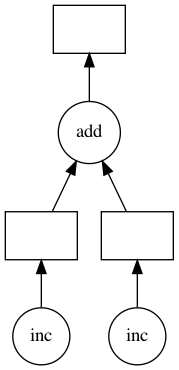

In [7]:
# Look at the task graph for `z`
z.visualize()

### More complex calculation

To visualize how graphs can be optimally or sub-optimally built, let's look at a more complex example.

In [8]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [9]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
total

CPU times: user 1.38 s, sys: 83.6 ms, total: 1.47 s
Wall time: 10 s


90

In [10]:
%%time
# Parallel code -- notice I moved the `delayed` to decorators

@delayed
def inc(x):
    sleep(1)
    return x + 1

@delayed
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = delayed(sum)(results)
total.compute()

CPU times: user 281 ms, sys: 15.5 ms, total: 296 ms
Wall time: 1.07 s


90

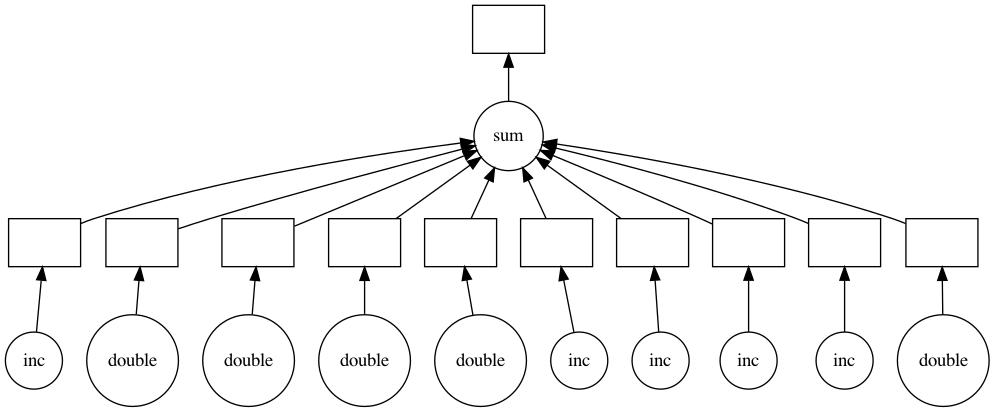

In [11]:
total.visualize()

### Why should you care about this?

By building a specification of the calculation we want to carry out before executing anything, we can pass the specification to an *execution engine* for evaluation. In the case of Dask, this execution engine could be running on many nodes of a cluster, so you have access to the full number of CPU cores and memory across all the machines. Dask will intelligently execute your calculation with care for minimizing the amount of data held in memory, while parallelizing over the tasks that make up a graph. Notice that in the animated diagram below, where four workers are processing the (simple) graph, execution progresses vertically up the branches first, so that intermediate results can be expunged before moving onto a new branch.

With `delayed` and normal pythonic looped code, very complex graphs can be built up and passed on to Dask for execution. See a nice example of [simulated complex ETL](https://blog.dask.org/2017/01/24/dask-custom) work flow.

![this](assets/animation.gif)

In [12]:
client.shutdown()

# Bag: Parallel Lists for semi-structured data

Dask-bag excels in processing data that can be represented as a sequence of arbitrary inputs. We'll refer to this as "messy" data, because it can contain complex nested structures, missing fields, mixtures of data types, etc. The *functional* programming style fits very nicely with standard Python iteration, such as can be found in the `itertools` module.

Messy data is often encountered at the beginning of data processing pipelines when large volumes of raw data are first consumed. The initial set of data might be JSON, CSV, XML, or any other format that does not enforce strict structure and datatypes.
For this reason, the initial data massaging and processing is often done with Python `list`s, `dict`s, and `set`s.

These core data structures are optimized for general-purpose storage and processing.  Adding streaming computation with iterators/generator expressions or libraries like `itertools` or [`toolz`](https://toolz.readthedocs.io/en/latest/) let us process large volumes in a small space.  If we combine this with parallel processing then we can churn through a fair amount of data.

Dask.bag is a high level Dask collection to automate common workloads of this form.  In a nutshell

    dask.bag = map, filter, toolz + parallel execution
    
**Related Documentation**

* [Bag documentation](https://docs.dask.org/en/latest/bag.html)
* [Bag screencast](https://youtu.be/-qIiJ1XtSv0)
* [Bag API](https://docs.dask.org/en/latest/bag-api.html)
* [Bag examples](https://examples.dask.org/bag.html)

### Create Data

In [13]:
%run prep.py -d accounts

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


Created CSV acccouts in 4.01s
Created JSON acccouts in 34.98s


In [14]:
from dask.distributed import Client

client = Client(n_workers=4)

### Bag Creation

You can create a `Bag` from a Python sequence, from files, from data on S3, etc.
We demonstrate using `.take()` to show elements of the data. (Doing `.take(1)` results in a tuple with one element)

Note that the data are partitioned into blocks, and there are many items per block. In the first example, the two partitions contain five elements each, and in the following two, each file is partitioned into one or more bytes blocks.

In [15]:
# each element is an integer
import dask.bag as db
b = db.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], npartitions=2)
b.take(3)

(1, 2, 3)

In [16]:
# each element is a text file, where each line is a JSON object
# note that the compression is handled automatically
import os
import json

lines = db.read_text(os.path.join('data', 'accounts.*.json.gz'))
js = lines.map(json.loads)
# take: inspect first few elements
js.take(1)

({'id': 1,
  'name': 'Edith',
  'transactions': [{'transaction-id': 107, 'amount': 7541},
   {'transaction-id': 331, 'amount': 8108},
   {'transaction-id': 335, 'amount': 7420},
   {'transaction-id': 407, 'amount': 7703},
   {'transaction-id': 489, 'amount': 7354},
   {'transaction-id': 587, 'amount': 8334},
   {'transaction-id': 603, 'amount': 7969},
   {'transaction-id': 645, 'amount': 6972},
   {'transaction-id': 707, 'amount': 7887},
   {'transaction-id': 925, 'amount': 6884},
   {'transaction-id': 1021, 'amount': 7287},
   {'transaction-id': 1175, 'amount': 7960},
   {'transaction-id': 1216, 'amount': 7495},
   {'transaction-id': 1387, 'amount': 7433},
   {'transaction-id': 1410, 'amount': 7182},
   {'transaction-id': 1530, 'amount': 7991},
   {'transaction-id': 1549, 'amount': 8005},
   {'transaction-id': 1708, 'amount': 7974},
   {'transaction-id': 1736, 'amount': 6878},
   {'transaction-id': 2364, 'amount': 7667},
   {'transaction-id': 2488, 'amount': 8358},
   {'transaction-id

We will use the fake dataset we've created of gzipped JSON data in your data directory.  This is like the example used in the `DataFrame` example we will see later, except that it has bundled up all of the entries for each individual `id` into a single record.  This is similar to data that you might collect off of a document store database or a web API.

Each line is a JSON encoded dictionary with the following keys

*  id: Unique identifier of the customer
*  name: Name of the customer
*  transactions: List of `transaction-id`, `amount` pairs, one for each transaction for the customer in that file

Once we parse our JSON data into proper Python objects (`dict`s, `list`s, etc.) we can perform more interesting queries by creating small Python functions to run on our data.

In [17]:
# filter: keep only some elements of the sequence
js.filter(lambda record: record['name'] == 'Alice').take(1)

({'id': 37,
  'name': 'Alice',
  'transactions': [{'transaction-id': 472, 'amount': 174},
   {'transaction-id': 1537, 'amount': 165},
   {'transaction-id': 3208, 'amount': 172},
   {'transaction-id': 3361, 'amount': 169},
   {'transaction-id': 4212, 'amount': 174},
   {'transaction-id': 4286, 'amount': 176},
   {'transaction-id': 5901, 'amount': 178},
   {'transaction-id': 7399, 'amount': 173},
   {'transaction-id': 7714, 'amount': 163},
   {'transaction-id': 9613, 'amount': 175},
   {'transaction-id': 9758, 'amount': 169},
   {'transaction-id': 10522, 'amount': 174},
   {'transaction-id': 10983, 'amount': 175},
   {'transaction-id': 11747, 'amount': 174},
   {'transaction-id': 12210, 'amount': 170},
   {'transaction-id': 12476, 'amount': 169},
   {'transaction-id': 12542, 'amount': 179},
   {'transaction-id': 13122, 'amount': 174},
   {'transaction-id': 13867, 'amount': 175},
   {'transaction-id': 14309, 'amount': 175},
   {'transaction-id': 14981, 'amount': 167},
   {'transaction-id'

In [18]:
def count_transactions(d):
    return {'name': d['name'], 'count': len(d['transactions'])}

# map: apply a function to each element
(js.filter(lambda record: record['name'] == 'Alice')
   .map(count_transactions)
   .take(5))

({'name': 'Alice', 'count': 134},
 {'name': 'Alice', 'count': 319},
 {'name': 'Alice', 'count': 220},
 {'name': 'Alice', 'count': 18},
 {'name': 'Alice', 'count': 136})

In [19]:
# pluck: select a field, as from a dictionary, element[field]
(js.filter(lambda record: record['name'] == 'Alice')
   .map(count_transactions)
   .pluck('count')
   .take(5))

(134, 319, 220, 18, 136)

In [20]:
# Average number of transactions for all of the Alice entries
(js.filter(lambda record: record['name'] == 'Alice')
   .map(count_transactions)
   .pluck('count')
   .mean()
   .compute())

204.026

In [21]:
client.shutdown()

# Arrays: analogous to Numpy Arrays

<img src="assets/dask-array.png" width="50%">

Dask array provides a parallel, larger-than-memory, n-dimensional array using blocked algorithms. Simply put: distributed Numpy.

*  **Parallel**: Uses all of the cores on your computer
*  **Larger-than-memory**:  Lets you work on datasets that are larger than your available memory by breaking up your array into many small pieces, operating on those pieces in an order that minimizes the memory footprint of your computation, and effectively streaming data from disk.
*  **Blocked Algorithms**:  Perform large computations by performing many smaller computations

Here, we'll build some understanding by implementing some blocked algorithms from scratch.
We'll then use Dask Array to analyze large datasets, in parallel, using a familiar NumPy-like API.

**Related Documentation**

* [Array documentation](https://docs.dask.org/en/latest/array.html)
* [Array screencast](https://youtu.be/9h_61hXCDuI)
* [Array API](https://docs.dask.org/en/latest/array-api.html)
* [Array examples](https://examples.dask.org/array.html)

### Create Data

In [22]:
%run prep.py -d random

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


Created random data for array exercise in 19.81s


In [23]:
from dask.distributed import Client

client = Client(n_workers=4)

### Blocked Algorithms

A *blocked algorithm* executes on a large dataset by breaking it up into many small blocks.

For example, consider taking the sum of a billion numbers.  We might instead break up the array into 1,000 chunks, each of size 1,000,000, take the sum of each chunk, and then take the sum of the intermediate sums.

We achieve the intended result (one sum on one billion numbers) by performing many smaller results (one thousand sums on one million numbers each, followed by another sum of a thousand numbers.)

We do exactly this with Python and NumPy in the following example:

In [24]:
# Load data with h5py
# this creates a pointer to the data, but does not actually load
import h5py
import os
f = h5py.File(os.path.join('data', 'random.hdf5'), mode='r')
dset = f['/x']

#### Compute Sum Using Blocked Algorithm

Before using dask, let's consider the concept of blocked algorithms. We can compute the sum of a large number of elements by loading them chunk-by-chunk, and keeping a running total.

Here we compute the sum of this large array on disk by 

1.  Computing the sum of each 1,000,000 sized chunk of the array
2.  Computing the sum of the 1,000 intermediate sums

Note that this is a sequential process in the notebook kernel, both the loading and summing.

In [25]:
%%time

# Compute sum of large array, one million numbers at a time
sums = []
for i in range(0, 1_000_000_000, 1_000_000):
    chunk = dset[i: i + 1_000_000]  # pull out numpy array
    sums.append(chunk.sum())

total = sum(sums)
total

CPU times: user 883 ms, sys: 1 s, total: 1.89 s
Wall time: 1.95 s


1000010204.0625

#### Compute Mean Using Blocked Algorithm

Now that we've seen the simple example above, try doing a slightly more complicated problem. Compute the mean of the array, assuming for a moment that we don't happen to already know how many elements are in the data.  You can do this by changing the code above with the following alterations:

1.  Compute the sum of each block
2.  Compute the length of each block
3.  Compute the sum of the 1,000 intermediate sums and the sum of the 1,000 intermediate lengths and divide one by the other

This approach is overkill for our case but does nicely generalize if we don't know the size of the array or individual blocks beforehand.

In [26]:
%%time

sums = []
lengths = []
for i in range(0, 1_000_000_000, 1_000_000):
    chunk = dset[i: i + 1_000_000]  # pull out numpy array
    sums.append(chunk.sum())
    lengths.append(len(chunk))

total = sum(sums)
length = sum(lengths)
total / length

CPU times: user 683 ms, sys: 535 ms, total: 1.22 s
Wall time: 1.19 s


1.0000102040625

### `dask.array` contains these algorithms

Dask.array is a NumPy-like library that does these kinds of tricks to operate on large datasets that don't fit into memory.  It extends beyond the linear problems discussed above to full N-Dimensional algorithms and a decent subset of the NumPy interface.

You can create a `dask.array` `Array` object with the `da.from_array` function.  This function accepts

1.  `data`: Any object that supports NumPy slicing, like `dset`
2.  `chunks`: A chunk size to tell us how to block up our array, like `(1_000_000,)`

In [27]:
import dask.array as da
x = da.from_array(dset, chunks=(1_000_000,))
x

dask.array<array, shape=(1000000000,), dtype=float32, chunksize=(1000000,), chunktype=numpy.ndarray>

Now that we have an `Array` we perform standard numpy-style computations like arithmetic, mathematics, slicing, reductions, etc..

The interface is familiar, but the actual work is different. `dask_array.sum()` does not do the same thing as `numpy_array.sum()`.

In [28]:
%%time 

result = x.sum()
result.compute()

CPU times: user 2.96 s, sys: 113 ms, total: 3.07 s
Wall time: 5.46 s


1000010200.0

In [29]:
%%time 

result = x.mean()
result.compute()

CPU times: user 1.84 s, sys: 61.5 ms, total: 1.9 s
Wall time: 3.03 s


1.0000101

### Performance and Parallelism

<img src="assets/fail-case.gif" width="40%" align="right">

In our first examples we used `for` loops to walk through the array one block at a time.  For simple operations like `sum` this is optimal.  However for complex operations we may want to traverse through the array differently.  In particular we may want the following:

1.  Use multiple cores in parallel
2.  Chain operations on a single blocks before moving on to the next one

`Dask.array` translates your array operations into a graph of inter-related tasks with data dependencies between them. Dask then executes this graph in parallel with multiple threads.



#### Example

1.  Construct a 20000x20000 array of normally distributed random values broken up into 1000x1000 sized chunks
2.  Take the mean along one axis
3.  Take every 100th element

In [30]:
import numpy as np
import dask.array as da

x = da.random.normal(10, 0.1, size=(20000, 20000),   # 400 million element array 
                              chunks=(1000, 1000))   # Cut into 1000x1000 sized chunks
y = x.mean(axis=0)[::100]                            # Perform NumPy-style operations

In [31]:
x.nbytes / 1e9  # Gigabytes of the input processed lazily

3.2

In [32]:
%%time

y.compute()     # Time to compute the result

CPU times: user 1.13 s, sys: 38.2 ms, total: 1.17 s
Wall time: 1.34 s


array([ 9.9995448 ,  9.99996055,  9.99898756,  9.99894536,  9.99971163,
       10.00014634, 10.00023615,  9.99867533, 10.00057959, 10.00013251,
        9.99877735,  9.99975823, 10.00035141, 10.00111201, 10.00095824,
       10.0001436 ,  9.9992607 , 10.00019998,  9.99918585, 10.00027708,
       10.0014034 ,  9.99993418, 10.00058631, 10.00008997,  9.999656  ,
        9.99987386, 10.00010253,  9.99960963,  9.99961663,  9.99964701,
       10.00105797,  9.9991494 ,  9.99966805, 10.00022704,  9.99976607,
        9.99990729,  9.99876798,  9.99987097, 10.00015794, 10.00062863,
       10.00023233, 10.00006062,  9.99959999,  9.99951237, 10.00006846,
       10.00013044,  9.99994292, 10.00057899,  9.99995689, 10.00047121,
       10.00000773,  9.99892913, 10.00047937,  9.99994692, 10.00043925,
       10.00017603,  9.99968372, 10.00024172,  9.9992128 , 10.00068941,
        9.99938285,  9.99959026, 10.00016617, 10.00125664,  9.99942822,
        9.99973289, 10.00048579,  9.99980449, 10.00017378, 10.00

#### NumPy: 19s, Needs gigabytes of memory

```python
import numpy as np

%%time 
x = np.random.normal(10, 0.1, size=(20000, 20000)) 
y = x.mean(axis=0)[::100] 
y

CPU times: user 19.6 s, sys: 160 ms, total: 19.8 s
Wall time: 19.7 s
```

#### Dask Array: 4s, Needs megabytes of memory

```python
import dask.array as da

%%time
x = da.random.normal(10, 0.1, size=(20000, 20000), chunks=(1000, 1000))
y = x.mean(axis=0)[::100] 
y.compute() 

CPU times: user 29.4 s, sys: 1.07 s, total: 30.5 s
Wall time: 4.01 s
```

In [33]:
client.shutdown()

# Dataframes: analagous to Pandas DataFrames

<img src="assets/dask-dataframe.png" width="50%">

In this section we use `dask.dataframe` to automatically build parallel dataframe computations over a directory of CSV files, for the common case of tabular computations.  Dask dataframes look and feel like Pandas dataframes but they run on the same infrastructure that powers `dask.delayed`.

Here, we'll create airline data, and we'll let `dask.dataframe` construct our computations for us.  The `dask.dataframe.read_csv` function can take a globstring like `"data/nycflights/*.csv"` and build parallel computations on all of our data at once.

### When to use `dask.dataframe`

Pandas is great for tabular datasets that fit in memory. Dask becomes useful when the dataset you want to analyze is larger than your machine's RAM. The demo dataset we're working with is only about 200MB, so that you can download it in a reasonable time, but `dask.dataframe` will scale to  datasets much larger than memory.

<img src="assets/pandas_logo.png" align="right" width="28%">

The `dask.dataframe` module implements a blocked parallel `DataFrame` object that mimics a large subset of the Pandas `DataFrame` API. One Dask `DataFrame` is comprised of many in-memory pandas `DataFrames` separated along the index. One operation on a Dask `DataFrame` triggers many pandas operations on the constituent pandas `DataFrame`s in a way that is mindful of potential parallelism and memory constraints.

**Related Documentation**

* [DataFrame documentation](https://docs.dask.org/en/latest/dataframe.html)
* [DataFrame screencast](https://youtu.be/AT2XtFehFSQ)
* [DataFrame API](https://docs.dask.org/en/latest/dataframe-api.html)
* [DataFrame examples](https://examples.dask.org/dataframe.html)
* [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)

**Main Take-aways**

1.  Dask DataFrame should be familiar to Pandas users
2.  The partitioning of dataframes is important for efficient execution

### Create Data

In [34]:
%run prep.py -d flights

- Downloading NYC Flights dataset... 

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


done
- Extracting flight data... done
- Creating json data... done
** Created flights dataset! in 18.56s**


In [35]:
from dask.distributed import Client

client = Client(n_workers=4)

### Reading and Viewing Dask DataFrames

Let's try to analyze an extract of flights in the USA across several years. This data is specific to flights out of the three airports in the New York City area.

In [36]:
import dask.dataframe as dd

df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})
df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,float64,object,object,float64,float64,float64,bool,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [37]:
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,False,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,False,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,False,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,False,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,False,0


### Computations with `dask.dataframe`

We compute the maximum of the `DepDelay` column. With just pandas, we would loop over each file to find the individual maximums, then find the final maximum over all the individual maximums

```python
maxes = []
for fn in filenames:
    df = pd.read_csv(fn)
    maxes.append(df.DepDelay.max())
    
final_max = max(maxes)
```

We could wrap that `pd.read_csv` with `dask.delayed` so that it runs in parallel. Regardless, we're still having to think about loops, intermediate results (one per file) and the final reduction (`max` of the intermediate maxes). This is just noise around the real task, which pandas solves with

```python
df = pd.read_csv(filename, dtype=dtype)
df.DepDelay.max()
```

`dask.dataframe` lets us write pandas-like code, that operates on larger than memory datasets in parallel.

In [38]:
%%time 

df['DepDelay'].max().compute()

CPU times: user 1.76 s, sys: 70.8 ms, total: 1.83 s
Wall time: 4.4 s


1435.0

In [39]:
%%time 

df.groupby('Origin')['DepDelay'].mean().compute()

CPU times: user 767 ms, sys: 32.4 ms, total: 800 ms
Wall time: 1.64 s


Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [40]:
client.shutdown()

# Futures interface

The Dask distributed scheduler implements a superset of Python's [`concurrent.futures`](https://docs.python.org/3/library/concurrent.futures.html) interface that allows for finer control and asynchronous computation.

In [41]:
from dask.distributed import Client

client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:62595 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 16.00 GiB


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [42]:
import time
import random

def inc(x):
    time.sleep(random.random())
    return x + 1

def double(x):
    time.sleep(random.random())
    return 2 * x
    
def add(x, y):
    time.sleep(random.random())
    return x + y 

We can run these functions locally

In [43]:
inc(1)

2

Or we can submit them to run remotely on a Dask worker node

In [44]:
future = client.submit(inc, 1)
future

<Future: pending, key: inc-8e0a31564998e7d9ef3ab85b18ffa1c3>

The `submit` function sends a function and arguments to the distributed scheduler for processing. It returns a `Future` object that refer to remote data on the cluster. The `Future` returns immediately while the computations run remotely in the background. There is no blocking of the local Python session.

If you wait a moment, and then check on the future again, you'll see that it has finished.

In [45]:
future

<Future: finished, type: builtins.int, key: inc-8e0a31564998e7d9ef3ab85b18ffa1c3>

Once the computation for a `Future` is complete, you can retrieve the result using the `.result()` method

In [46]:
future.result()

2

### Specifying task dependencies

Much like the `delayed` interface, we can submit tasks based on other futures. This will create a dependency between the inputs and outputs. Dask will track the execution of all tasks and ensure that downstream tasks are run at the proper time and place and with the proper data.

In [47]:
x = client.submit(inc, 1)
y = client.submit(double, 2)
z = client.submit(add, x, y)
z

<Future: pending, key: add-f90c64be930e9620aeacd6fca2b9a5d6>

In [48]:
z.result()

6

As an example, we can submit many tasks that depend on each other in a `for`-loop

In [49]:
%%time

zs = []

for i in range(64):
    x = client.submit(inc, i)     # x = inc(i)
    y = client.submit(double, x)  # y = inc(x)
    z = client.submit(add, x, y)  # z = inc(y)
    zs.append(z)

total = client.submit(sum, zs)

CPU times: user 97.4 ms, sys: 7.25 ms, total: 105 ms
Wall time: 100 ms


In [51]:
total

<Future: finished, type: builtins.int, key: sum-9963cdfa333d82f2e4a90f4fac4df0d1>

In [52]:
total.result()

6240

In [ ]:
client.shutdown()